In [1]:
import os
import zipfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
from tensorflow import keras
from transformers import TFAlbertModel

In [2]:
data_root = '../../data/'
local_zip = data_root + 'msra.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('../../data/')
zip_ref.close()

In [3]:
def get_data_path(data_dir=data_root + 'msra/', type='train'):
    if type in ['train', 'val', 'test']:
        sentences_path = os.path.join(data_dir, type, 'sentences.txt')
        tags_path = os.path.join(data_dir, type, 'tags.txt')
        return sentences_path, tags_path
    else:
        raise ValueError("data type not in ['train', 'val', 'test']")


In [4]:
max_len = 128
batch_size = 32
model_name = 'clue/albert_chinese_tiny'
saved_model = 'ner_albert_tiny_text_input'

In [5]:
class Label_Tokenizer(object):
    def __init__(self, labels, max_length):
        super().__init__()
        self.size = len(labels)
        labels_to_ids = {k: v for v, k in enumerate(labels)}
        ids_to_labels = {v: k for v, k in enumerate(labels)}
        self.labels_to_ids = labels_to_ids
        self.ids_to_labels = ids_to_labels
        self.max_length = max_length

    def tokenize(self, labels):
        tokens = [self._tokenize(label) for label in labels]
        return tokens

    def _tokenize(self, label):
        label = label.decode('utf-8') if hasattr(label, 'decode') else label
        labels = [le for le in label.strip().split(' ')]
        special_token = self.encode(['O'])[0]

        tokens = self.encode(labels)
        tokens = tokens[:self.max_length - 2]
        tokens = [special_token] + tokens + [special_token]
        # Add padded TAG tokens
        padding_len = self.max_length - len(tokens)
        tokens = tokens + ([special_token] * padding_len)
        return tokens

    def encode(self, labels):
        return [self.labels_to_ids[label] for label in labels]

    def decode(self, ids):
        return [self.ids_to_labels[id] for id in ids]


In [6]:
labels = ['O', 'B-ORG', 'I-PER', 'B-PER', 'I-LOC', 'I-ORG', 'B-LOC']
label_tokenizer = Label_Tokenizer(labels, max_length=max_len)
labels_num = label_tokenizer.size

In [7]:
class Preprocessor(object):
    def __init__(self, vocab_path, seq_length):
        super().__init__()
        self.tokenize = tfm.nlp.layers.FastWordpieceBertTokenizer(
            vocab_file=vocab_path,
            lower_case=True)
        self.bert_pack_inputs = tfm.nlp.layers.BertPackInputs(
            seq_length=seq_length,
            special_tokens_dict=self.tokenize.get_special_tokens_dict())

vocab_path = './vocab.txt'
preprocessor = Preprocessor(vocab_path, seq_length=max_len)


2022-06-21 13:23:04.237163: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:362] The empty string is found in the vocabulary, which takes place in the token id space but will never be used in the result. Consider cleaning it from the vocabulary.
2022-06-21 13:23:04.237556: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:374] The empty suffix token is found in the vocabulary, which takes place in token id space but will (almost) never be used in the result. Consider cleaning it from the vocabulary.


In [8]:
def get_type_data(type, max_lines=None):
  sentences_file, labels_file = get_data_path(type=type)
  sentences = tf.data.TextLineDataset(sentences_file).prefetch(tf.data.experimental.AUTOTUNE)
  if(max_lines != None):
    sentences = sentences.take(max_lines)
  x = [sentence for sentence in sentences.as_numpy_iterator()]
  x = tf.constant(x)

  labels = tf.data.TextLineDataset(labels_file).prefetch(tf.data.experimental.AUTOTUNE)
  if(max_lines != None):
    labels = labels.take(max_lines)
  labels = [label.decode('utf-8') for label in labels.as_numpy_iterator()]
  y = label_tokenizer.tokenize(labels)
  y = tf.constant(y)
  print(len(y))
  return x, y

def get_dataset(max_lines=None):
  val_max_lines = None
  if(max_lines != None):
    val_max_lines = int(max_lines / 10)
  train = get_type_data('train', max_lines)
  val = get_type_data('val', val_max_lines)
  test = get_type_data('test', val_max_lines)
  return train, val, test

In [9]:
train, val, test = get_dataset()
x_train, y_train = train
x_val, y_val = val
x_test, y_test = test

2022-06-21 13:23:04.308415: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


42000
3000
3442


In [10]:
def create_model(labels_num):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    tokenize = hub.KerasLayer(preprocessor.tokenize, trainable=True)
    bert_pack_inputs = hub.KerasLayer(preprocessor.bert_pack_inputs, trainable=True)
    encoder_inputs = bert_pack_inputs([tokenize(text_input)])

    encoder = TFAlbertModel.from_pretrained(model_name, from_pt=True, trainable=True)
    outputs = encoder(
        input_ids=encoder_inputs['input_word_ids'], token_type_ids=encoder_inputs['input_type_ids'], attention_mask=encoder_inputs['input_mask']
    )

    embedding = outputs[0]
    embedding = keras.layers.Dropout(0.3)(embedding)
    logits = keras.layers.Dense(
        labels_num + 1, activation='softmax', name='NER')(embedding)
    
    model = keras.Model(
        inputs=[text_input],
        outputs=[logits],
    )
    optimizer = keras.optimizers.Adam(learning_rate=3e-5)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics=tf.metrics.SparseCategoricalAccuracy(name='accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


In [11]:
model = create_model(labels_num)
model.summary()

2022-06-21 13:23:06.678201: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.LayerNorm.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertMode

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['keras_layer[0][0]']            
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                      

In [12]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=3,
    verbose=1,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)


Epoch 1/3


/Users/mng/miniforge3/envs/c3-nlp/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1313/1313 [==============================] - 678s 514ms/step - loss: 0.0666 - accuracy: 0.9799 - val_loss: 0.0286 - val_accuracy: 0.9909
Epoch 2/3
1313/1313 [==============================] - 686s 523ms/step - loss: 0.0262 - accuracy: 0.9916 - val_loss: 0.0228 - val_accuracy: 0.9926
Epoch 3/3
1313/1313 [==============================] - 700s 533ms/step - loss: 0.0193 - accuracy: 0.9938 - val_loss: 0.0199 - val_accuracy: 0.9936


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


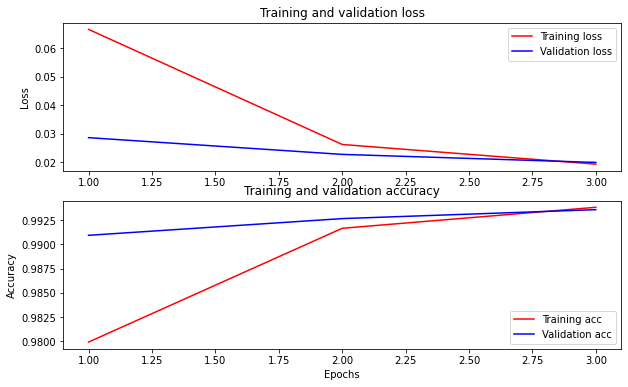

In [13]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [14]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

108/108 [==============================] - 26s 244ms/step - loss: 0.0219 - accuracy: 0.9931
Loss: 0.021929632872343063
Accuracy: 0.9931135773658752


In [15]:
def predict_from_text(text, model):
    x_test = tf.constant([text])
    pred_test = model.predict(x_test) if hasattr(model, 'predict') else model(x_test)
    # ignore predictions of padding tokens
    pred_tags = np.argmax(pred_test, 2)[0]

    tags = label_tokenizer.decode(pred_tags)[:len(text) + 2]
    res = []
    words = {
        'word': '',
        'tag': None
    }
    for idx, tag in enumerate(tags):
        if(tag != 'O'):
            pre, suf = tag.split('-')
            words['tag'] = suf
            word = text[idx-1]
            # word = tokenizer.decode(token)
            # word = preprocessor.decode(word)
            words['word'] = words['word'] + word if words['word'] else word
        else:
            if(words['tag']):
                res.append(words)
            words = {
                'word': '',
                'tag': None
            }
    return pd.DataFrame(res)


In [19]:
test_inputs = '李华住在朝阳区香河园街道西坝河北里，在5月4号去过天安门广场，5号下午去了太阳宫凯德茂商场。'

In [20]:
print(predict_from_text(test_inputs, model))


            word  tag
0             李华  PER
1  朝阳区香河园街道西坝河北里  LOC
2          天安门广场  LOC
3       太阳宫凯德茂商场  LOC


In [18]:
model.save(saved_model, include_optimizer=False)


INFO:tensorflow:Assets written to: ner_albert_tiny_text_input/assets


INFO:tensorflow:Assets written to: ner_albert_tiny_text_input/assets
